### Work 1 - MNIST MLP

Provide you realization of MLP with backpropogation using MNIST dataset. Use `numpy` and vector operations.

In [1]:
from IPython.display import HTML, Math, Latex, Markdown, display

# ----- load data 
import numpy as np

# ----- plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from random import shuffle
import time

# ----- dataset and utils 
from tensorflow.keras.datasets import mnist          # only for dataset loading
from keras.utils.np_utils import to_categorical      # only to categorization of labels

Using TensorFlow backend.


In [2]:
class _history:
    def __init__(self):
        self.epoch = []
        self.history = {}

    def add(self, **kwargs):
        self.epoch.append(len(self.epoch))
        for k, i in kwargs.items():
            data = self.history.get(k, [])
            data.append(i)
            self.history.update({k: data})

# mlp with backpropogation

class mlp:
    def __init__(self):
        self.layers = []
        self.weights = [np.array([0])]
        self.bias = [np.array([0])]
        self.eta = 0.1
        self.eta = 0.1
        self.h = _history()

    @staticmethod
    def normalize_images(data_images):
        """
            transform 28*28 into 784 -> reshape data.
            this is no production solution, way to expencive to move this
            data there and back.
        """
        if len(data_images.shape) == 3:
            data_images = data_images.reshape(
                data_images.shape[0],
                data_images.shape[1] * data_images.shape[2])

        return data_images

    @staticmethod
    def normalize_labels(data_labels):
        if len(data_labels.shape) != 2:
            data_labels = to_categorical(data_labels)

        return data_labels

    def init_weights_and_bias(self):

        low = self._layers[0]['dim']
        for layer in self._layers[1:]:
            dim = layer['dim']
            self.bias.append(np.random.randn(dim, self.batch))
            self.weights.append(np.random.randn(dim, low) * np.sqrt(2.0 / low))
            low = dim

    def update_weights_and_bias(self, weights, bias):
        for i in range(len(self._layers)):
            self.bias[i] = self.bias[i] - (self.eta / self.batch) * bias[i]
            self.weights[i] = self.weights[i] - (self.eta /
                                                 self.batch) * weights[i]

    # our perseptron intrastructure

    def add(self, size=None, activator=None):
        if size is None or activator is None:
            raise ValueError("Please provide data")
        self.layers.append({'dim': size, 'act': activator})

    def fit(self,
            data_images,
            data_labels,
            epoch=5,
            batch=32,
            verbose=0,
            validation_split=0.0):

        assert len(data_images) == len(data_labels), 'Input data Dimensions'
        assert 0.0 <= validation_split < 1.0, "Validation split error"

        split_at = 0
        if validation_split > 0.0:
            split_at = int(len(data_images) * validation_split)
            valid_images = data_images[:split_at]
            valid_labels = data_labels[:split_at]

        data_images_in = mlp.normalize_images(data_images[split_at:])
        data_labels_in = mlp.normalize_labels(data_labels[split_at:])

        # final layers.
        self._layers = [{'dim': data_images_in.shape[1], 'act': 'relu'}]
        for layer in self.layers:
            self._layers.append(layer)

        # should i delete this?
        self.batch = batch
        self.epoch = epoch
        self.init_weights_and_bias()

        for epochn in range(epoch):
            string = "Epoch {}: Starting...".format(epochn + 1)
            print(string, end="")

            start = time.time()

            random_set = np.random.permutation(range(data_images_in.shape[0]))
            chunks = len(random_set) // batch

            indexes = [
                random_set[idx:idx + batch]
                for idx in range(0, len(random_set), batch)
            ]
            batches = [data_images_in[idxs] for idxs in indexes]
            labels = [data_labels_in[idxs] for idxs in indexes]

            for idx, images in enumerate(batches):

                if len(images) != batch:
                    continue

                a_l = self.feedforward(images)
                adjusted = self.backprop(a_l, labels[idx].T, images)
                self.update_weights_and_bias(*adjusted)

            end = time.time()

            # bias normalization
            for i in range(1, len(self.bias)):
                self.bias[i] = np.sum(self.bias[i], axis=1) / self.batch
                self.bias[i].shape = self.bias[i].shape[0], 1

            acc = {'acc': self.validate(data_images, data_labels)}
            if split_at:
                acc.update({'val_acc': acc})
            self.h.add(**acc)

            print("\r" + " " * len(string), end="")

            report = {'time': end - start}
            report.update(**acc)

            message = ["{}: {:3.5f}".format(k, v) for k, v in report.items()]
            string = "\rEpoch {}: {} ".format(epochn + 1, " / ".join(message))
            print(string)

        return self.h

    def feedforward(self, data):
        """ simple feed forward -> going down to layers and return a's """
        s, a = [np.array([0])], [np.array([0])]
        for idx in range(1, len(self._layers)):
            matrix = a[-1] if len(a) > 1 else data.T
            s.append(self.weights[idx] @ matrix + self.bias[idx])
            activator = self._activators(self._layers[idx]['act'])
            a.append(activator(s[-1]))
        return a

    def backprop(self, a_l, labels, images):
        """ simple backpropogation """
        bias, weights = [], []

        d_l = a_l[-1] - labels
        bias.append(d_l)
        weights.append(d_l @ a_l[-2].T)

        j = 0
        for i in range(len(self._layers) - 2, 0, -1):

            activator = self._activators('diff_{}'.format(
                self._layers[i]['act']))
            decents = self.weights[i + 1].T @ bias[j] * activator(a_l[i])
            bias.append(decents)
            j += 1
            weights.append(bias[j] @ (images if i == 1 else a_l[i - 1].T))

        bias.append(np.array([0]))
        weights.append(np.array([0]))

        return weights[::-1], bias[::-1]

    # ----- Predictions and Validation.
    def predict(self, data_images):
        """ return predicted labels """
        data_images_in = mlp.normalize_images(data_images)
        layers = self.feedforward(data_images_in)
        return np.argmax(layers[-1], axis=0)

    def validate(self, data_images, data_labels):
        """ accuracy """
        x = (self.predict(data_images) == data_labels)
        valid = np.where(x == True)
        return len(valid[0]) / len(x)

    # ---- Activators API
    def _activators(self, name):
        """ activators wrapper """
        activators = {
            name.replace('activator_', ''): getattr(code, '__func__')
            for name, code in self.__class__.__dict__.items()
            if name.startswith('activator_')
        }

        return activators.get(name, None)

    @staticmethod
    def activator_relu(x):
        return (x) * (x > 0)

    @staticmethod
    def activator_diff_relu(x):
        x[x > 0] = 1
        x[x <= 0] = 0
        return x

    @staticmethod
    def activator_tanh(x):
        return np.tanh(x)

    @staticmethod
    def activator_diff_tanh(x):
        return 1 - np.tanh(x) * np.tanh(x)

    @staticmethod
    def activator_softmax(x):
        result = np.zeros(shape=(x.shape[0], 1))
        frac = np.zeros(shape=(x.shape[0], 1))
        for i in range(x.shape[1]):
            num = np.exp(x[:, i] - np.max(x[:, i]))
            denom = np.sum(num)
            frac = num / denom
            frac = frac.reshape(x.shape[0], 1)
            result = np.hstack((result, frac))

        return result[:, 1:]

In [3]:
# lab utils
def imagegrid(data, col=12, row=5, imagesize=28, rand=True, colors=[ "gist_gray" ]):
    """ dataset images preview """
    
    if rand is False:
        np.random.seed(42)
    perm = np.random.choice(np.arange(data.shape[0]), col*row, replace=False)
    
    # fig size = height_x_width or rows_x_cols     
    size = (row, col)
    fig = plt.figure(figsize=size)
    
    # fig size = width_x_height or cols_x_rows
    fig.set_size_inches((col, row))
    
    # index to row and col converters     
    row_idx = lambda i: i//col  
    col_idx = lambda i: i - row_idx(i)*col 
    

    for i, idx in enumerate(perm):
        ax = plt.subplot2grid(size, ( row_idx(i), col_idx(i) ) )
        image = data[idx].reshape(imagesize, imagesize) 
        ax.imshow(image, cmap=colors[i%len(colors)], interpolation='bilinear')
        ax.axis('Off')
        ax.set_title("")
    fig.subplots_adjust(hspace=.1,wspace=0)
    
def testset(data, labels, n):
    """return n random images and corresponsing labes """
    perm = np.random.choice(np.arange(data.shape[0]), n, replace=False)
    return data[perm], labels[perm]

def plot_prediction(test_drive_images, actual, expected, imagesize=28, labels=[]):
    """ plot results of prediction and hilight actual classes """
    
    
    # mapping dictionary
    values = {}
    max_vals = 0
    for i, cls in enumerate(actual):
        r = values.get(cls, {})
        r.update({int(i): cls == expected[i]})
        values.update({cls: r})
        max_vals = max(len(r), max_vals)
    
    text_width  = 2
    text_height = 6
    
    classes = 10
    
    rows = max_vals+1 if max_vals+1 > text_height else text_height
    cols = classes + text_width
    
    layout = (rows, cols)
    fig = plt.figure(figsize=(layout[1], layout[0]))
    
    ax = plt.subplot2grid(layout, (0, 10), colspan=text_width, rowspan=text_height )
    ax.axis('Off')
    text = "\n".join([f"{i}) {s}" for i,s in enumerate(labels)])
    ax.text(1, 1, text,   ha='left', va='top', size=20 )
    
    for i in range(classes):
        ax = plt.subplot2grid(layout, (0, i) )
        ax.axis('Off')
        ax.text(0.1,0.1, i, ha='center', va='center', size=20 )
    
    rows_counter = {}
    for cls, items in values.items():
        for idx, valid in items.items(): 
            row_image = rows_counter.get(cls, 1)
            rows_counter.update({cls: row_image+1})
            ax = plt.subplot2grid(layout, (row_image, cls) )
        
            image = test_drive_images[idx].reshape(imagesize, imagesize) 
            ax.imshow(image, cmap="gray" if valid else "inferno", interpolation='bilinear')
            if not valid:
                ax.text(.2, .2, expected[idx], ha='left', va='top', size=13, color="w" )
                
            ax.axis('Off') 

def history(data):
    """ plots history graphs """
    with plt.xkcd():
        fig = plt.figure(figsize=(14, 4))
        layout = (1, 2)

        top  = plt.subplot2grid(layout, (0, 0), colspan=2)  
                
        colors = list('bgcmk')
        
        labels = {
            'acc'      : 'Training Accuracy',
            'val_acc'  : 'Validation Accuracy', 
        }
        
        
        shuffle(colors)
        for k, l in enumerate(['acc', 'val_acc']):
            if l in data.history:
                top.plot(data.history[l], color=colors[k], label=labels[l]) 
        
 
         # common things
        top.legend(loc="best")
        top.set_xlim(0, max(data.epoch))
        top.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: int(x+1)))
            
        fig.tight_layout()

### Step 1: Load data

In [4]:
clss = list(range(0,10))

In [5]:
(data_images, data_labels), (test_images, test_labels) = mnist.load_data()

### Visualization

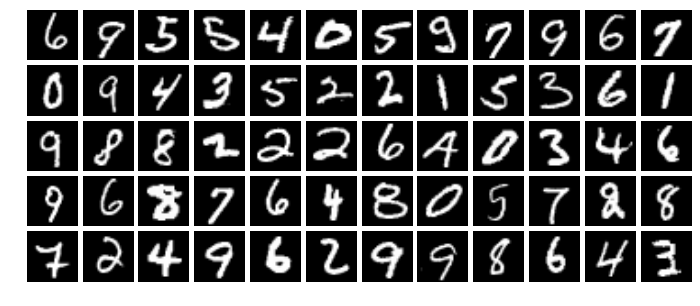

In [6]:
imagegrid(data=data_images, imagesize=28)

In [7]:
data_images.shape,  data_labels.shape, test_images.shape,  test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [8]:
display(Markdown("## Lowering dataset resolution and shrinking dataset training size"))

data_images = data_images / 255
test_images = test_images / 255

train_set_size = int(data_images.shape[0]/10)
train_set_size = 50000
#-------------
"train set size", train_set_size

## Lowering dataset resolution and shrinking dataset training size

('train set size', 50000)

### Step 2 - Model Creating and Training

Epoch 1: time: 3.06789 / acc: 0.93300 
Epoch 2: time: 2.93121 / acc: 0.95944 
Epoch 3: time: 2.85410 / acc: 0.96994 
Epoch 4: time: 2.84426 / acc: 0.97552 
Epoch 5: time: 2.87690 / acc: 0.97814 
Epoch 6: time: 2.81884 / acc: 0.98290 
Epoch 7: time: 2.95784 / acc: 0.98450 
Epoch 8: time: 2.88692 / acc: 0.98682 
Epoch 9: time: 2.86763 / acc: 0.99018 
Epoch 10: time: 2.90386 / acc: 0.98316 


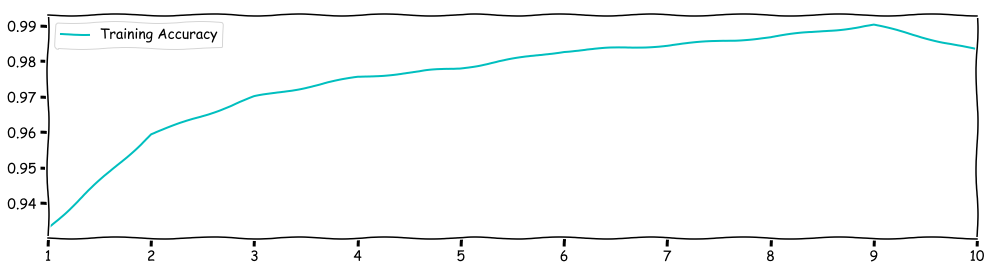

In [9]:
model = mlp()
model.add(64, 'relu')     # available activators relu/tanh
model.add(10, 'softmax') 

history(model.fit(
    data_images[:train_set_size], 
    data_labels[:train_set_size], 
    epoch=10, 
    batch=25, 
))

### Step 3 - Validation

In [10]:
display(Markdown("### Testing \"test\" set (acc)"))

model.validate(test_images, test_labels)

### Testing "test" set (acc)

0.9665

In [11]:
display(Markdown("### Testing rest of training set (acc)"))

model.validate(data_images[train_set_size:], data_labels[train_set_size:])

### Testing rest of training set (acc)

0.9674

### Random(100) images from test set prediction visualization

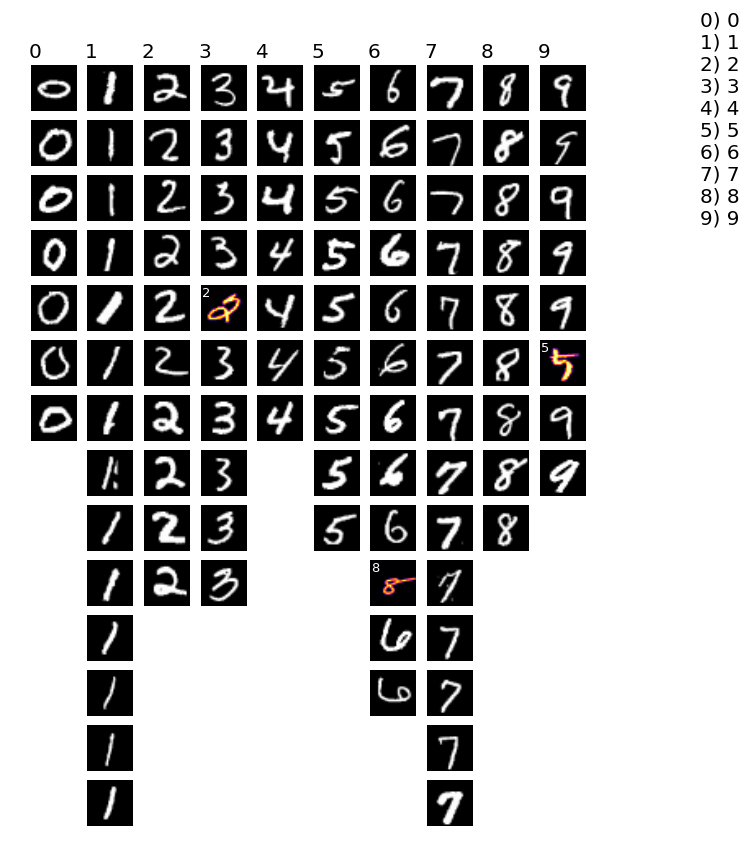

In [12]:
display(Markdown("### Random(100) images from test set prediction visualization"))

test_drive_images, test_drive_labels = testset(test_images, test_labels, 100)
predicts = model.predict(test_drive_images) 
plot_prediction(test_drive_images, predicts, test_drive_labels, imagesize=28, labels=clss)